# Proyecto 3: Siniestros Viales en Bogotá
Jessenia Piza, Sebastián Martínez, Manuela Acosta


### Introducción 

A través de este notebook se desarrollará un estudio del dataset de Siniestros Viales en Bogotá, el cual cuenta con un reporte alfanumérico de los incidentes en los informes policiales de accidentes de tránsito ocurridos en Bogotá desde el año 2015. El objetivo de este proyecto es evaluar el problema de series temporales con diferentes modelos para evaluar el comportamiento de estas y determinar si se puede predecir de manera óptima un dato en el futuro sobre los accidentes en Bogotá.

# Secciones

* [Preparación de los datos.](#prep)
* [Análisis exploratorio de los datos.](#exp)
* [Series temporales](#series_temp)
 * [Evaluar Modelos](#evaluar_modelos)
     * [Modelo de persistencia para la predicción](#modelo_persistencia)
     * [Forecasting](#forecasting)
     * [ARIMA](#arima)
* [Evaluación de los modelos](#validacion)
* [Conclusiones](#conclusiones)

## Preparación de los datos <a class="anchor" id="prep">

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [1]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [51]:
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order

En primer lugar, importamos los datos con los que trabajaremos.

In [3]:
excel_file = pd.ExcelFile("siniestros_viales_consolidados_bogota_dc.xlsx", engine="openpyxl")

Arreglamos el formato de la columna titulada "fecha".

In [187]:
siniestros = excel_file.parse(sheet_name='SINIESTROS',
                        dtype={'SINIESTROS': np.float32},
                        index_col = 'FECHA',
                        parse_dates=True, 
                        date_parser=lambda fecha: pd.datetime.strptime(fecha, '%d/%m/%Y'),
                       )

In [5]:
siniestros

,CODIGO_ACCIDENTE,HORA,GRAVEDAD,CLASE,CHOQUE,OBJETO_FIJO,DIRECCION,CODIGO_LOCALIDAD,DISENO_LUGAR
FECHA,,,,,,,,,
2015-01-01,4401438,01:05:00,2,2,NaN,NaN,KR 64A-CL 2C 02,16,2
2015-01-01,4401449,05:50:00,2,3,NaN,NaN,AV AVENIDA DEL SUR-KR 65A 41,7,1
2015-01-01,4401430,07:15:00,2,3,NaN,NaN,KR 19D-CL 62 S 02,19,1
2015-01-01,4401453,09:30:00,3,1,1.0,NaN,KR 79-CL 42F S 71,8,1
2015-01-01,4401423,09:45:00,2,1,1.0,NaN,CL 66A-KR 76 02,10,2
...,...,...,...,...,...,...,...,...,...
2020-12-31,10530481,21:20:00,3,1,1.0,NaN,CL 42-KR 86 S 02,8,1
2020-12-31,10530439,21:30:00,2,1,1.0,NaN,KR 111-CL 171 02,11,2
2020-12-31,10530491,21:34:00,3,1,1.0,NaN,CL 134-KR 5 08,1,1


Ahora, contamos el número de accidentes por día, lo cual nos servirá más tarde como variable de predicción.

In [6]:
siniestros.groupby('FECHA').count()

,CODIGO_ACCIDENTE,HORA,GRAVEDAD,CLASE,CHOQUE,OBJETO_FIJO,DIRECCION,CODIGO_LOCALIDAD,DISENO_LUGAR
FECHA,,,,,,,,,
2015-01-01,13,13,13,13,8,0,13,13,13
2015-01-02,52,52,52,52,42,5,52,52,52
2015-01-03,41,41,41,41,30,0,41,41,41
2015-01-04,42,42,42,42,35,2,42,42,42
2015-01-05,69,69,69,69,59,3,69,69,69
...,...,...,...,...,...,...,...,...,...
2020-12-27,35,35,35,35,29,3,35,35,35
2020-12-28,67,67,67,67,62,7,67,67,67
2020-12-29,72,72,72,72,62,1,72,72,72


El conteo antes mostrado lo colocamos como una columna nueva en el dataframe de siniestros. Esto con el fin de luego realizar los modelos correspondientes a series temporales.

In [9]:
count_siniestros_fecha = siniestros.groupby('FECHA').count()['CODIGO_ACCIDENTE']
count_np = np.zeros((siniestros.shape[0],1))

In [10]:
for i in range(siniestros.shape[0]):
    count_np[i] = count_siniestros_fecha[siniestros.index[i]]

In [11]:
siniestros['COUNT'] = count_np

Importamos todas las hojas del archivo de Excel con las que trabajaremos. Tanto la hoja titulada `ACTOR_VIAL` como la titulada `SINIESTROS` tienen información relevante, entonces las concatenaremos. Cabe aclarar que al concatenarlas, algunas filas de `SINIESTROS` se repetirán, ya que esta hoja contiene la información de cada accidente, en general, mientras que `ACTOR_VIAL` contiene la información de cada persona presente en cada accidente.

In [12]:
siniestros

,CODIGO_ACCIDENTE,HORA,GRAVEDAD,CLASE,CHOQUE,OBJETO_FIJO,DIRECCION,CODIGO_LOCALIDAD,DISENO_LUGAR,COUNT
FECHA,,,,,,,,,,
2015-01-01,4401438,01:05:00,2,2,NaN,NaN,KR 64A-CL 2C 02,16,2,13.0
2015-01-01,4401449,05:50:00,2,3,NaN,NaN,AV AVENIDA DEL SUR-KR 65A 41,7,1,13.0
2015-01-01,4401430,07:15:00,2,3,NaN,NaN,KR 19D-CL 62 S 02,19,1,13.0
2015-01-01,4401453,09:30:00,3,1,1.0,NaN,KR 79-CL 42F S 71,8,1,13.0
2015-01-01,4401423,09:45:00,2,1,1.0,NaN,CL 66A-KR 76 02,10,2,13.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-31,10530481,21:20:00,3,1,1.0,NaN,CL 42-KR 86 S 02,8,1,52.0
2020-12-31,10530439,21:30:00,2,1,1.0,NaN,KR 111-CL 171 02,11,2,52.0
2020-12-31,10530491,21:34:00,3,1,1.0,NaN,CL 134-KR 5 08,1,1,52.0


In [13]:
actor_vial = excel_file.parse(sheet_name = 'ACTOR_VIAL')
vehiculos = excel_file.parse(sheet_name = 'VEHICULOS')
hipotesis = excel_file.parse(sheet_name = 'HIPOTESIS')
diccionario = excel_file.parse(sheet_name = 'DICCIONARIO')

In [14]:
zeros = np.zeros((actor_vial.shape[0], siniestros.shape[1]-2))

In [15]:
actor_via = np.array(actor_vial)
new_np = np.column_stack((actor_via, zeros))
index = []
for i in range(new_np.shape[0]):
    codigo = new_np[i][0]
    new_np[i,8:] = siniestros[siniestros['CODIGO_ACCIDENTE'] == codigo].iloc[:, 2:].values
    index.append(siniestros.index[siniestros['CODIGO_ACCIDENTE'] == codigo].to_list()[0])

In [16]:
new_df = pd.DataFrame(new_np, index = index)
new_df.columns = actor_vial.columns.append(siniestros.columns[2:])
new_df = new_df.drop(['FECHA'], axis = 1)

In [17]:
new_df

,CODIGO_ACCIDENTE,CODIGO_ACCIDENTADO,CONDICION,ESTADO,EDAD,SEXO,VEHICULO,GRAVEDAD,CLASE,CHOQUE,OBJETO_FIJO,DIRECCION,CODIGO_LOCALIDAD,DISENO_LUGAR,COUNT
2015-01-01,4401447,2452576,CONDUCTOR,ILESO,44,FEMENINO,4401447-1,3,1,1.0,NaN,CL 72-KR 91A 45,10,1,13.0
2015-01-01,4401447,2452577,CONDUCTOR,ILESO,31,MASCULINO,4401447-2,3,1,1.0,NaN,CL 72-KR 91A 45,10,1,13.0
2015-01-01,4401453,2452586,CONDUCTOR,ILESO,47,MASCULINO,4401453-1,3,1,1.0,NaN,KR 79-CL 42F S 71,8,1,13.0
2015-01-01,4401453,2452587,CONDUCTOR,ILESO,29,MASCULINO,4401453-2,3,1,1.0,NaN,KR 79-CL 42F S 71,8,1,13.0
2015-01-01,4401423,2452500,CONDUCTOR,HERIDO,44,MASCULINO,4401423-1,2,1,1.0,NaN,CL 66A-KR 76 02,10,2,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,10530492,12728799,CONDUCTOR,ILESO,27,MASCULINO,10530492-2,3,1,1.0,NaN,CL 13-KR 96 02,9,1,52.0
2020-12-31,10530494,12728800,CONDUCTOR,ILESO,39,MASCULINO,10530494-1,3,1,1.0,NaN,KR 37-CL 7 49,16,1,52.0
2020-12-31,10530494,12728801,CONDUCTOR,ILESO,55,MASCULINO,10530494-2,3,1,1.0,NaN,KR 37-CL 7 49,16,1,52.0
2020-12-31,10530493,12728802,CONDUCTOR,ILESO,55,MASCULINO,10530493-1,3,1,1.0,NaN,KR 22-CL 60 S 02,19,2,52.0


# Análisis exploratorio de los datos <a class="anchor" id="exp">
    
Una vez organizados los dataframes con los que trabajaremos, procedemos a realizar el análisis exploratorio de los datos.
    
A continuación podemos observar las columnas del dataframe con el que trabajaremos. Todas estas brindan información acerca de cada uno de los accidentes.

In [18]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 422416 entries, 2015-01-01 to 2020-12-31
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   CODIGO_ACCIDENTE    422416 non-null  object
 1   CODIGO_ACCIDENTADO  422416 non-null  object
 2   CONDICION           422416 non-null  object
 3   ESTADO              422416 non-null  object
 4   EDAD                422416 non-null  object
 5   SEXO                422416 non-null  object
 6   VEHICULO            398969 non-null  object
 7   GRAVEDAD            422416 non-null  object
 8   CLASE               422416 non-null  object
 9   CHOQUE              363809 non-null  object
 10  OBJETO_FIJO         10551 non-null   object
 11  DIRECCION           422416 non-null  object
 12  CODIGO_LOCALIDAD    422416 non-null  object
 13  DISENO_LUGAR        422416 non-null  object
 14  COUNT               422416 non-null  object
dtypes: object(15)
memory usage: 51.6+ M

Verificamos los valores perdidos del dataset.

In [19]:
new_df.isna().sum()

CODIGO_ACCIDENTE           0
CODIGO_ACCIDENTADO         0
CONDICION                  0
ESTADO                     0
EDAD                       0
SEXO                       0
VEHICULO               23447
GRAVEDAD                   0
CLASE                      0
CHOQUE                 58607
OBJETO_FIJO           411865
DIRECCION                  0
CODIGO_LOCALIDAD           0
DISENO_LUGAR               0
COUNT                      0
dtype: int64

Aunque tenemos valores perdidos, estos datos no representan mayor información en nuestro objetivo. Por ende, eliminamos las columnas correspondientes a estos datos. Luego, verificamos nuevamente los valores nulos.

In [20]:
new_df = new_df.drop(['VEHICULO', 'CHOQUE', 'OBJETO_FIJO'], axis=1)
new_df.isna().sum()

CODIGO_ACCIDENTE      0
CODIGO_ACCIDENTADO    0
CONDICION             0
ESTADO                0
EDAD                  0
SEXO                  0
GRAVEDAD              0
CLASE                 0
DIRECCION             0
CODIGO_LOCALIDAD      0
DISENO_LUGAR          0
COUNT                 0
dtype: int64

Observamos una primera descripción estadística de los dataframes a utilizar.

In [21]:
new_df.describe()

,CODIGO_ACCIDENTE,CODIGO_ACCIDENTADO,CONDICION,ESTADO,EDAD,SEXO,GRAVEDAD,CLASE,DIRECCION,CODIGO_LOCALIDAD,DISENO_LUGAR,COUNT
count,422416,422416,422416,422416,422416,422416,422416,422416,422416,422416,422416,422416.0
unique,196004,422416,5,3,114,3,3,7,92475,20,13,143.0
top,4425548,2452576,CONDUCTOR,ILESO,27,MASCULINO,3,1,KR 80-CL 2 51,8,1,111.0
freq,75,1,306534,325025,12725,347718,260632,363817,432,48365,323648,11006.0


Podemos ver que hay un total de 422.416 filas en nuestro dataframe, es decir, hay esta cantidad de actores viales. Sin embargo, el total de accidentes es de 196.004. 

In [22]:
siniestros.describe()

,CODIGO_ACCIDENTE,GRAVEDAD,CLASE,CHOQUE,OBJETO_FIJO,CODIGO_LOCALIDAD,DISENO_LUGAR,COUNT
count,1.961520e+05,196152.000000,196152.000000,167910.000000,6689.000000,196152.000000,196152.000000,196152.000000
mean,6.997374e+06,2.636873,1.221955,1.127717,5.318583,9.216424,1.420312,97.450722
std,2.976910e+06,0.511668,0.653418,0.610152,3.756058,5.015592,1.284176,22.978264
min,4.401419e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000
25%,4.451508e+06,2.000000,1.000000,1.000000,2.000000,6.000000,1.000000,84.000000
50%,4.501210e+06,3.000000,1.000000,1.000000,5.000000,9.000000,1.000000,101.000000
75%,1.048079e+07,3.000000,1.000000,1.000000,10.000000,12.000000,1.000000,113.000000
max,1.053701e+07,3.000000,7.000000,5.000000,16.000000,20.000000,13.000000,155.000000


Además, si observamos específicamente la información contenida en `siniestros`, podemos obtener la siguiente información: 
- La gravedad promedio de los accidentes es 2.64. Es decir, la mayoría de los accidentes tienen heridos o solo daños.
- Más del 75% de los accidentes tienen gravedad 2 o 3, es decir, muy pocos accidentes tienen muertes.
- El 50% de los accidentes tiene gravedad 3, es decir, solo daños. REVISAR
- Más del 75% de los accidentes fueron de clase 1, que corresponde a choque.

Ahora, para analizar el dataframe `actor_vial`, debemos cambiar los valores que indican que no hay información, que son strings, por NaN. 

In [23]:
actor_vial['EDAD'] = actor_vial['EDAD'].replace(['SIN INFORMACION'], np.nan)
actor_vial['SEXO'] = actor_vial['SEXO'].replace(['SIN INFORMACION'], np.nan)

Además, las columnas que corresponden a variables categóricas las convertimos a numéricas con get_dummies, y eliminamos otras que no brindan mayor información. 

In [24]:
actor_vial = actor_vial[['CODIGO_ACCIDENTE', 'CODIGO_ACCIDENTADO', 'CONDICION', 'ESTADO', 'EDAD', 'SEXO', 'VEHICULO']]

In [25]:
actor_vial = pd.get_dummies(actor_vial, columns = ["CONDICION", "ESTADO", "SEXO"])

In [26]:
actor_vial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422416 entries, 0 to 422415
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   CODIGO_ACCIDENTE                422416 non-null  int64  
 1   CODIGO_ACCIDENTADO              422416 non-null  int64  
 2   EDAD                            414505 non-null  float64
 3   VEHICULO                        398969 non-null  object 
 4   CONDICION_CICLISTA              422416 non-null  uint8  
 5   CONDICION_CONDUCTOR             422416 non-null  uint8  
 6   CONDICION_MOTOCICLISTA          422416 non-null  uint8  
 7   CONDICION_PASAJERO/ACOMPAÑANTE  422416 non-null  uint8  
 8   CONDICION_PEATON                422416 non-null  uint8  
 9   ESTADO_HERIDO                   422416 non-null  uint8  
 10  ESTADO_ILESO                    422416 non-null  uint8  
 11  ESTADO_MUERTO                   422416 non-null  uint8  
 12  SEXO_FEMENINO   

In [27]:
print('Ciclistas accidentados: ', actor_vial['CONDICION_CICLISTA'].value_counts()[1])
print('Conductores accidentados: ', actor_vial['CONDICION_CONDUCTOR'].value_counts()[1])
print('Motociclistas accidentados: ', actor_vial['CONDICION_MOTOCICLISTA'].value_counts()[1])
print('Pasajero/acompañante accidentados: ', actor_vial['CONDICION_PASAJERO/ACOMPAÑANTE'].value_counts()[1])
print('Peatones accidentados: ', actor_vial['CONDICION_PEATON'].value_counts()[1])

Ciclistas accidentados:  12780
Conductores accidentados:  306534
Motociclistas accidentados:  52290
Pasajero/acompañante accidentados:  27365
Peatones accidentados:  23447


In [28]:
print('Cantidad heridos: ', actor_vial['ESTADO_HERIDO'].value_counts()[1])
print('Cantidad ilesos: ', actor_vial['ESTADO_ILESO'].value_counts()[1])
print('Cantidad muertos: ', actor_vial['ESTADO_MUERTO'].value_counts()[1])

Cantidad heridos:  94317
Cantidad ilesos:  325025
Cantidad muertos:  3074


In [29]:
print('Cantidad hombres: ', actor_vial['SEXO_MASCULINO'].value_counts()[1])
print('Cantidad mujeres: ', actor_vial['SEXO_FEMENINO'].value_counts()[1])

Cantidad hombres:  347718
Cantidad mujeres:  65059


In [30]:
print('Edad promedio: ', actor_vial['EDAD'].mean())

Edad promedio:  37.786374108876856


Así, de `actor_vial`, podemos obtener la siguiente información:
- El mayor número de accidentados corresponde a conductores, con un total de 306.534. 
- El menor número de accidentados es de peatones, con un total de 23.447.
- La mayoría de personas accidentadas terminaron ilesas, mientras que la menor cantidad de accidentados murió.
- La mayoría de accidentados eran hombres, con un total de 347.718, mientras que mujeres accidentadas fueron 65.059.

Ahora, veremos si hay correlación en los datos.

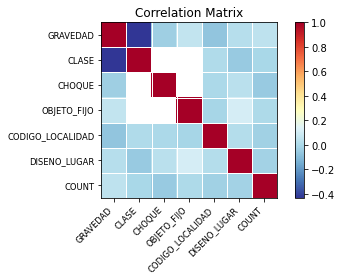

In [31]:
corr = siniestros.set_index('CODIGO_ACCIDENTE').corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()

Así, podemos observar que hay baja correlación entre las variables de 'siniestros'.

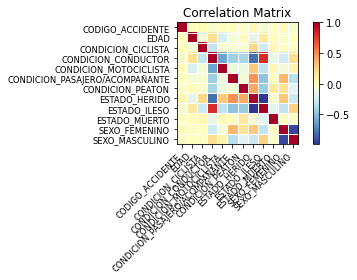

In [32]:
corr2 = actor_vial.set_index('CODIGO_ACCIDENTADO').corr()
sm.graphics.plot_corr(corr2, xnames=list(corr2.columns))
plt.show()

Nuevamente, observamos que las variables no están correlacionadas.

Ahora, hacemos esos cambios de variables categóricas a numéricas en el dataframe `new_df`.

In [33]:
new_df = pd.get_dummies(new_df, columns = ["CONDICION", "ESTADO", "SEXO"])

In [34]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 422416 entries, 2015-01-01 to 2020-12-31
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   CODIGO_ACCIDENTE                422416 non-null  object
 1   CODIGO_ACCIDENTADO              422416 non-null  object
 2   EDAD                            422416 non-null  object
 3   GRAVEDAD                        422416 non-null  object
 4   CLASE                           422416 non-null  object
 5   DIRECCION                       422416 non-null  object
 6   CODIGO_LOCALIDAD                422416 non-null  object
 7   DISENO_LUGAR                    422416 non-null  object
 8   COUNT                           422416 non-null  object
 9   CONDICION_CICLISTA              422416 non-null  uint8 
 10  CONDICION_CONDUCTOR             422416 non-null  uint8 
 11  CONDICION_MOTOCICLISTA          422416 non-null  uint8 
 12  CONDICION_PASA

# Series temporales<a class="anchor" id="series_temp">

Tomamos de siniestros el conteo de todos los accidentes por fecha.

In [199]:
count_df = siniestros.groupby(by=["FECHA"]).count()['CODIGO_ACCIDENTE']
count_df = pd.DataFrame(count_df)
count_df.columns = ['COUNT']

Creamos la serie temporal con los valores de conteo antes especificados.

In [201]:
# create a time series
s = pd.Series(count_df.unstack().values, index=count_df.index)

In [202]:
s.head()

FECHA
2015-01-01    13
2015-01-02    52
2015-01-03    41
2015-01-04    42
2015-01-05    69
dtype: int64

Observamos la señal temporal.

<AxesSubplot:xlabel='FECHA'>

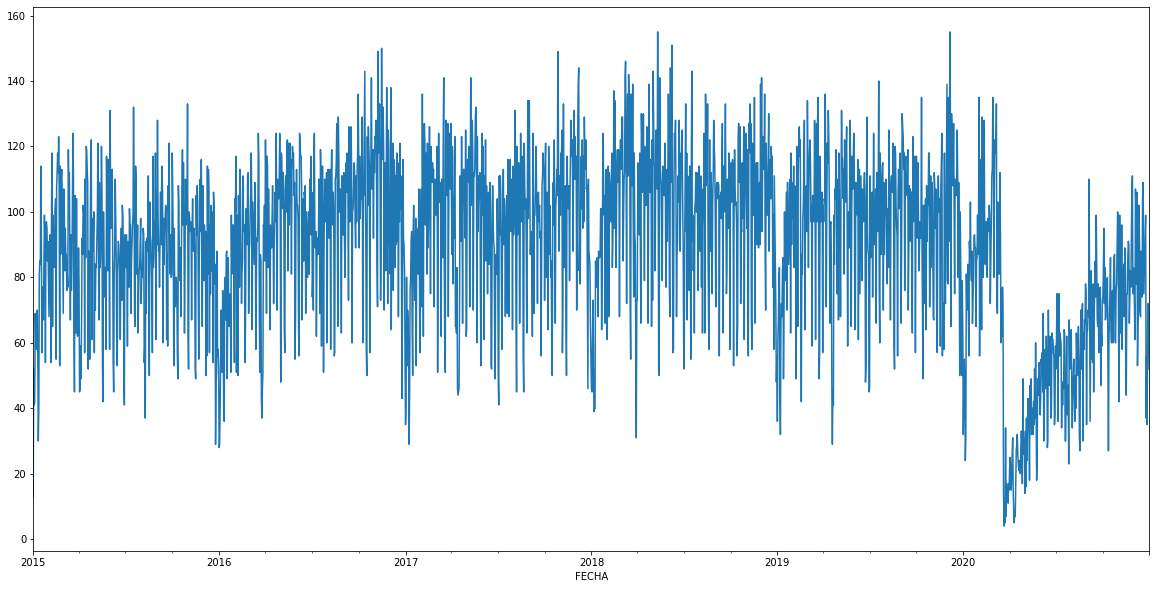

In [203]:
s.plot(figsize=(20,10))

#### Prueba-Dickey-Fuller-aumentada

Hacemos la prueba de raíz unitaria.

In [204]:
# calculate stationarity test of time series data
X = s.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.323091
p-value: 0.000405
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Por una gran diferencia notamos que la ADF Statistic es más pequeña que el valor crítico del 10%. Esto implica que el proceso no tiene raíz unitaria y por ende, la señal de tiempo es estacionaria o no depende del tiempo. Esto tiene sentido dado que se ve en los datos que los accidentes de un día no dependen mucho de las fechas anteriores.

## Evaluar modelos<a class="anchor" id="evaluar_modelos">

Dividimos los datos en datos de prueba y entrenamiento para utilizarlos más adelante en los modelos.

In [205]:
# calculate a train-test split of a time series dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [206]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 2192
Training Observations: 1446
Testing Observations: 746


Observamos la parte de la señal que corresponde a cada uno de las divisiones expresadas anteriormente.

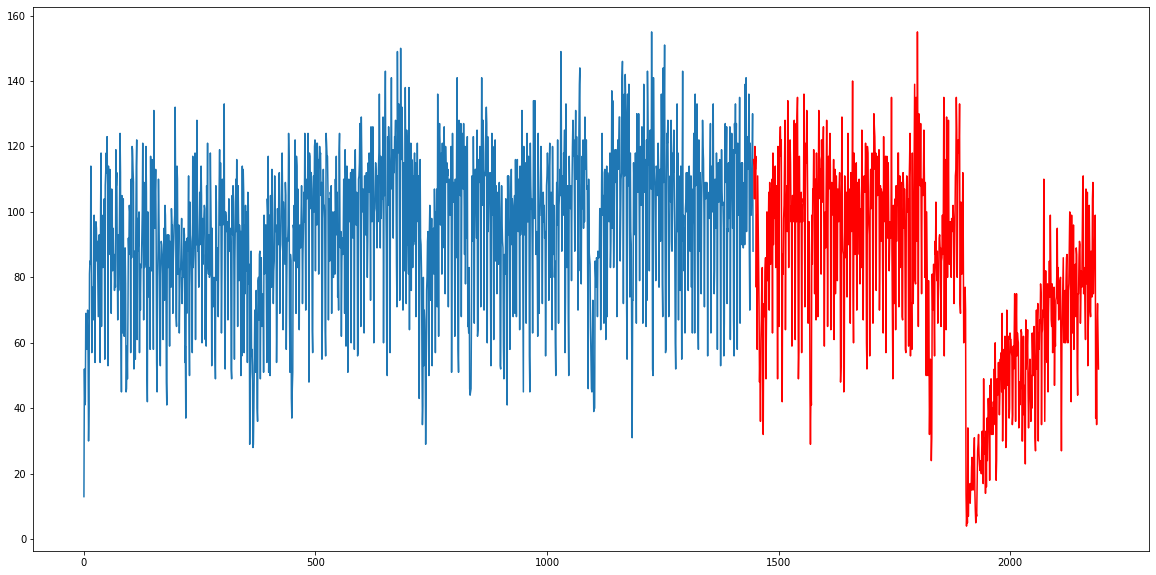

In [207]:
# plot train-test split of time series data
plt.figure(figsize=(20,10))
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r');

### Modelo de persistencia para la predicción<a class="anchor" id="modelo_persistencia">

Para utilizar Forecasting más adelante, primero realizaremos el modelo de persistencia para la predicción con el objetivo de tener como referencia un baseline para resultados posteriores.

In [208]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
df.index = count_df.index
df.head()

,t,t+1
FECHA,,
2015-01-01,NaN,13
2015-01-02,13.0,52
2015-01-03,52.0,41
2015-01-04,41.0,42
2015-01-05,42.0,69


Dividimos los datos en entenamiento y prueba.

In [209]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

Creamos el modelo.

In [210]:
# persistence model
def model_persistence(x):
    return x

Hallamos el conjunto de predicciones evaluando el modelo de persistencia con cada uno de los datos de prueba.

In [211]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.539


Dado que los datos de la serie temporal van de 0 a 100, podemos determinar que el Test RMSE antes mostrado no es tan malo para el modelo. Por ende, el modelo es lo suficientemente bueno para los datos utilizados.

En la siguiente gráfica observamos que las predicciones realizadas en el conjunto de prueba son muy similares a los datos reales de la serie temporal. Así, logramos visualizar lo dicho anteriormento con la métrica del RMSE.

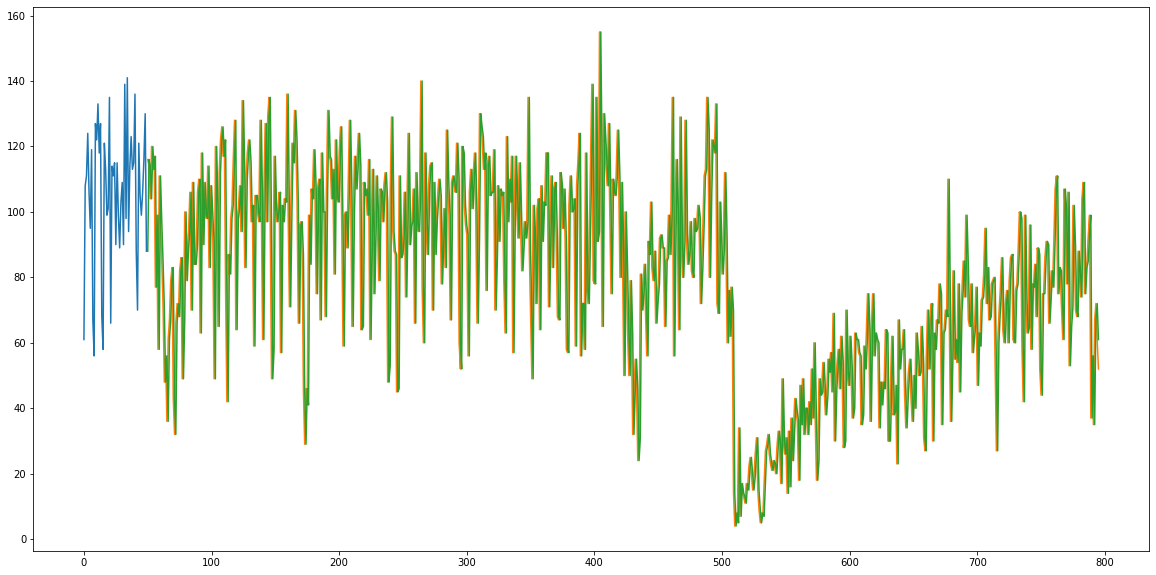

In [212]:
# plot predictions and expected results on the test data
plt.figure(figsize=(20,10))
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions]);

### Visualize Residual Forecast Errors

Si bien el modelo anterior ya dijimos que era bueno, visualizaremos los errores residuales para validar esta conclusión previa.

In [213]:
# calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

Observamos los errores residuales. Sin embargo, esta vez no podemos sacar mucha información de la gráfica.

<AxesSubplot:>

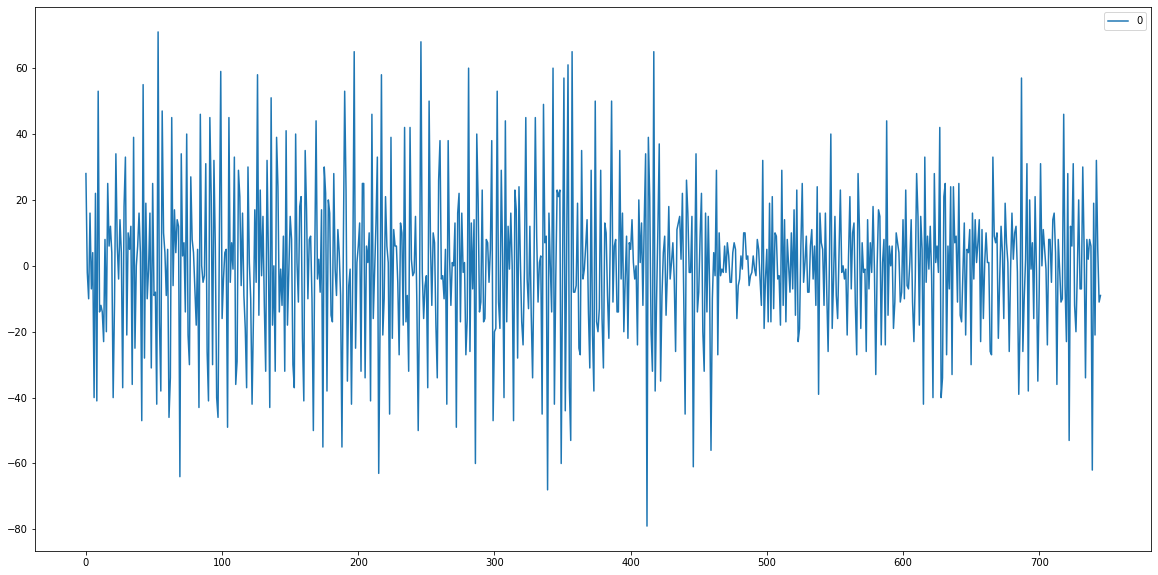

In [214]:
# plot residuals
residuals.plot(figsize=(20,10))

Aunque los errores residuales se ven distribuidos entre -79 y 71, observamos que la media de los errores residuales es cercana a 0. Esto nos indica que no hay sesgo en los pronósticos o bien, el sesgo es demasiado pequeño.

In [215]:
residuals.describe()

,0
count,746.000000
mean,-0.048257
std,23.554371
min,-79.000000
25%,-14.000000
50%,0.500000
75%,13.000000
max,71.000000


Observamos un histograma de los residuos y verificamos que estos se distribuyen alrededor del 0.

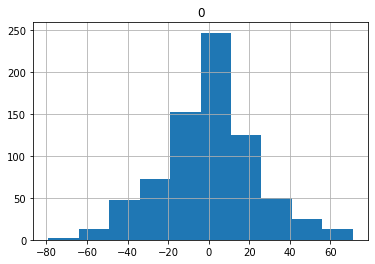

In [224]:
# histograms plot
residuals.hist();

#### Residual Autocorrelation

En la siguiente gráfica se observa la autocorrelación de los residuales. Aquí, notamos que aunque se pasan en un principio del umbral determinado, luego todos los residuos terminan dentro del umbral. Esto nos indica que no se espera que haya una correlación entre los residuos o que esta sea demasiado pequeña.

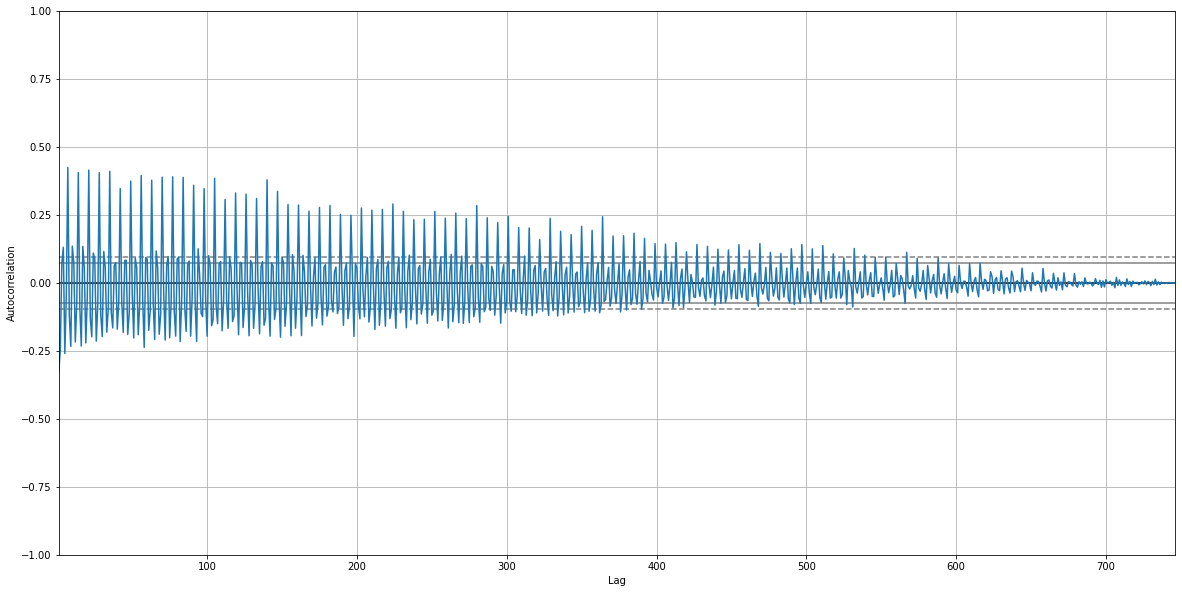

In [217]:
plt.figure(figsize=(20,10))
autocorrelation_plot(residuals);

In [219]:
mod = ar_select_order(count_df, maxlag=14, glob=True)
mod.ar_lags

array([ 1,  2,  3,  4,  6,  7,  8,  9, 12, 14])

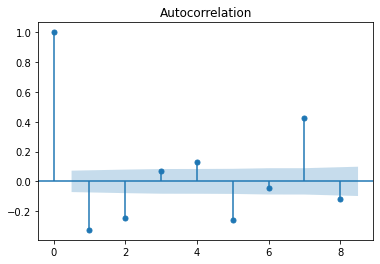

In [228]:
# autocorrelation plot of residuals as a line plot
plot_acf(residuals, lags=8)
plt.show()

## Forecasting<a class="anchor" id="forecasting">

Ahora, realizaremos Forecasting con los datos de entrenamiento y el número de periodos anteriores óptimos hallados anteriormente por la función `ar_select_order`.

In [229]:
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

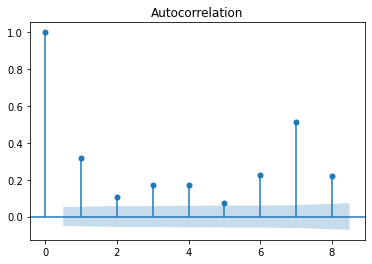

In [231]:
plot_acf(train, lags=8)
plt.show()

El siguiente modelo a realizar es el modelo de autorregresión. Este halla con los datos de entrenamiento y el número de lags.

In [256]:
# train autoregression
model = AR(train,lags=8)
model_fit = model.fit()
window = model_fit.ar_lags[-1]
coef = model_fit.params

Observamos los coeficientes del modelo.

In [257]:
print('Lag: %s' % model_fit.ar_lags)
print('Coefficients: %s' % model_fit.params)

Lag: [1 2 3 4 5 6 7 8]
Coefficients: [ 2.51060142e+01  2.22438230e-01 -1.84516811e-02  5.29052782e-02
  5.13958289e-02 -5.13557613e-02  8.08731402e-02  4.40195815e-01
 -4.08473716e-02]


Hallamos las predicciones del modelo evaluando cada uno de los datos de prueba en el modelo autorregresivo.

In [258]:
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = []
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

Obtenemos el RMSE el cual es de 18.986. Notamos nuevamente que por la distribución de la señal de tiempo, este es un RMSE bueno para el modelo, lo que nos indica que el modelo predice de manera correcta.

In [261]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18.986


Observamos la predicción en la siguiente gráfica comparados con los datos originales de la señal de tiempo. Notamos que se apacigua un poco la señal, sin embargo, los datos de predicción siguen una forma parecida a los originales.

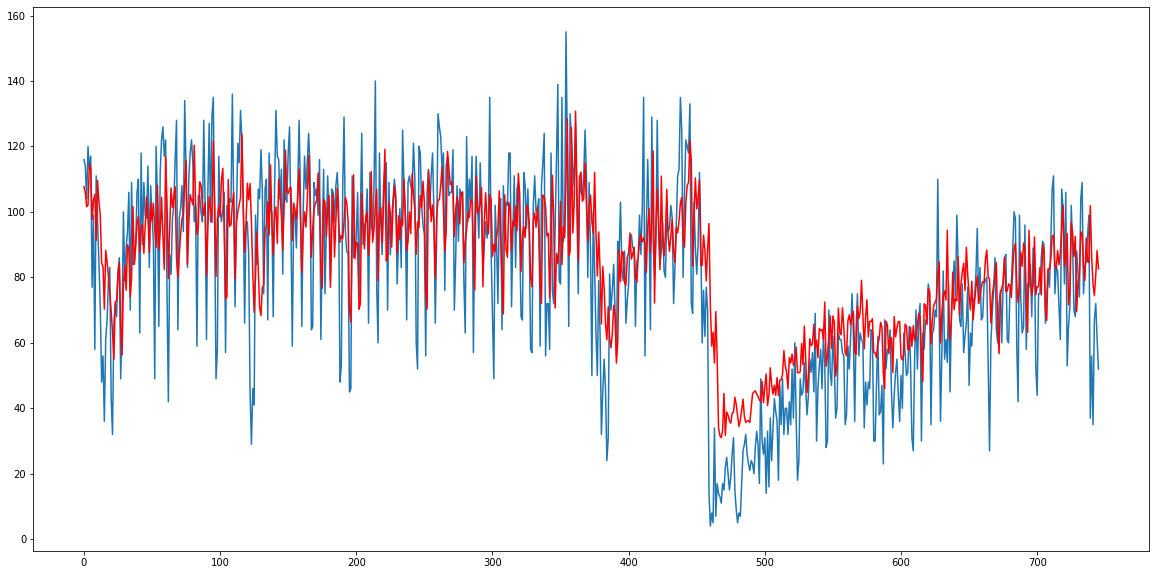

In [262]:
plt.figure(figsize=(20,10))
plt.plot(test)
plt.plot(predictions, color='red');

### ARIMA<a class="anchor" id="arima">

Por último, realizamos el modelo ARIMA. Para este, utilizaremos dos funciones. El objetivo es evaluar el modelo de ARIMA para algún orden dado, la idea es dar diferentes ordenes y hallar con cuál de estos el RSME es menor. A partir de ahí, evaluar el modelo completo con el orden óptimo.

In [263]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [265]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [266]:
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]
evaluate_models(s.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=32.544
ARIMA(0, 0, 1) RMSE=26.569
ARIMA(0, 1, 0) RMSE=23.539
ARIMA(0, 1, 1) RMSE=20.022
ARIMA(1, 0, 0) RMSE=23.963
ARIMA(1, 0, 1) RMSE=20.084
ARIMA(1, 1, 0) RMSE=22.248
ARIMA(1, 1, 1) RMSE=19.828
ARIMA(2, 0, 0) RMSE=23.335
ARIMA(2, 0, 1) RMSE=20.335
ARIMA(2, 1, 0) RMSE=20.480
ARIMA(2, 1, 1) RMSE=19.597
Best ARIMA(2, 1, 1) RMSE=19.597


Mirando los resulatados anteriores al evaluar los parámetros para el modelo de ARIMA, encontramos que los mejores órdenes, para el mejor modelo, son (2,1,1).

In [267]:
model = ARIMA(s, order=(2,1,1))
model_fit = model.fit()

In [268]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2192
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -9739.511
Date:                Sun, 21 Nov 2021   AIC                          19487.023
Time:                        00:31:04   BIC                          19509.791
Sample:                    01-01-2015   HQIC                         19495.344
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1412      0.023      6.018      0.000       0.095       0.187
ar.L2         -0.1576      0.025     -6.287      0.000      -0.207      -0.108
ma.L1         -0.8446      0.015    -57.746      0.0

Graficamos los residuales del modelo de ARIMA.

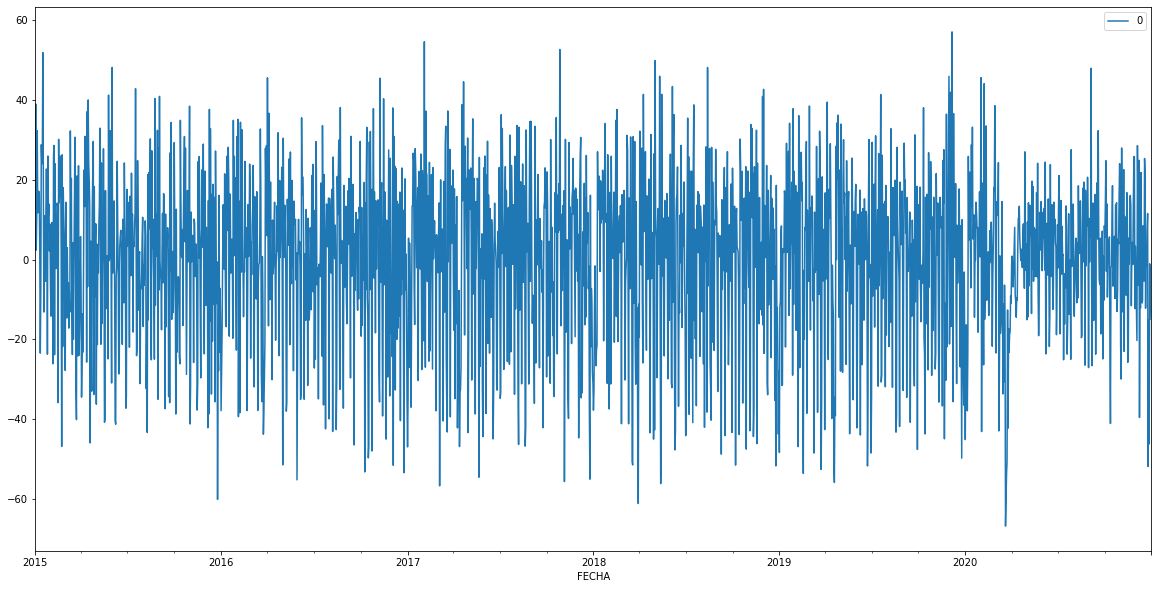

In [270]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(20,10))
plt.show()

Observamos que parecido al modelo de AR, este está centrado en 0, por lo que el sesgo de evaluación no es muy alto. 

[(-150.0, 150.0)]

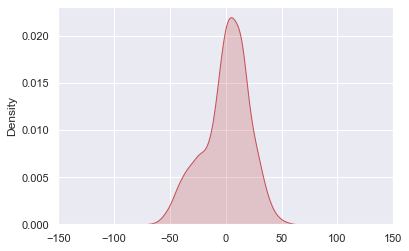

In [276]:
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-150, 150))

Complementando lo dicho anteriormente, la media de los elemntos residuales es muy cercana a 0, verificando la conclusión anterior. Además, los datos van de aproximadamente -67 a 57.

In [277]:
residuals.describe()

,0
count,2192.000000
mean,0.103107
std,20.624367
min,-66.763127
25%,-11.242309
50%,2.863557
75%,14.181897
max,57.059159


## Evaluación de los modelos<a class="anchor" id="validacion">

Realizamos validación cruzada para series temporales para determinar cuál de los modelos realizados es mejor.

In [279]:
test_period = 10
cv_timeseries = TimeSeriesSplit(n_splits=10)
rmse_AR = []
rmse_ARIMA = []
for train, test in cv_timeseries.split(count_df):
    train_df = count_df.iloc[train,:]
    test_df = count_df.iloc[test, :]
    
    # MODELO AUTERREGRESIÓN
    AR_model = AR(train_df, lags = 8)
    AR_model_fit = AR_model.fit()
    AR_predict = AR_model_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1, dynamic=False)
    
    # MODELO ARIMA
    ARIMA_model = ARIMA(train_df, order=(2,1,1))
    ARIMA_model_fit = ARIMA_model.fit()
    ARIMA_predict = ARIMA_model_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
    
    # RMSE DE LOS MODELOS
    rmse_AR.append(np.sqrt(mean_squared_error(test_df[:test_period], AR_predict[:test_period])))
    rmse_ARIMA.append(np.sqrt(mean_squared_error(test_df[:test_period], ARIMA_predict[:test_period])))

In [282]:
print(f"El promedio del RMSE para el modelo de Autorregresión es: {np.mean(rmse_AR)}")
print(f"El promedio del RMSE para el modelo de ARIMA es: {np.mean(rmse_ARIMA)}")

El promedio del RMSE para el modelo de Autorregresión es: 16.95791114393085
El promedio del RMSE para el modelo de ARIMA es: 20.052730269119827


# Conclusiones<a class="anchor" id="conclusiones">
- La mayoría de los accidentes ocurridos en los últimos años son causados por conductores, en su mayoría hombres, con una edad promedio de 31 años. Más del 75% de los accidentados terminaron ilesos, y la cantidad de muertes es relativamente pequeña con respecto al total de accidentes.

- Evaluando los parámetros para el modelo de ARIMA, encontramos que los mejores órdenes, para el mejor modelo, son (2,1,1). Esto se debe a que el RSME es el menor.
    
    - El valor de p es 2, que corresponde al orden de retraso, e indica el valor para la autoregresión. Este orden es el número de valores históricos utilizados para predecir el valor en el momento actual. Es decir, sólo se utilizan dos años para predecir el valor del siguiente año.

    - El valor d es 1, es decir, un grado de diferenciación 1, lo que nos dice que la serie temporal es estacionaria. Esto implica que su distribución y sus parámetros no varían con el tiempo, luego, no siguen una tendencia.
    
    - El valor q es 1, y corresponde al orden de la media móvil. Al ser 1, esto nos dice que la influencia de los datos anteriores no es tan grande sobre los datos actuales. Es decir, se tienen en cuenta datos recientes para realizar la predicción.

- El modelo de autorregresión (AR) indica un RSME menor que el hallado en el modelo de ARIMA. Esto indica que es el modelo que mejor predice la serie de tiempo. Al graficarla, nos dimos cuenta que con respecto a los datos originales, en la predicción se atenuaba la señal. Sin embargo, la forma de la original no cambiada, por ende, el RSME no es tan bajo pero tampoco es tan alto, por lo que hace que sea el mejor modelo evaluado en este proyecto.
